C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_m

RMSE (Rolling): 1100.87
MAPE (Rolling): 0.1854 (18.54%)


C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\pablo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertibl

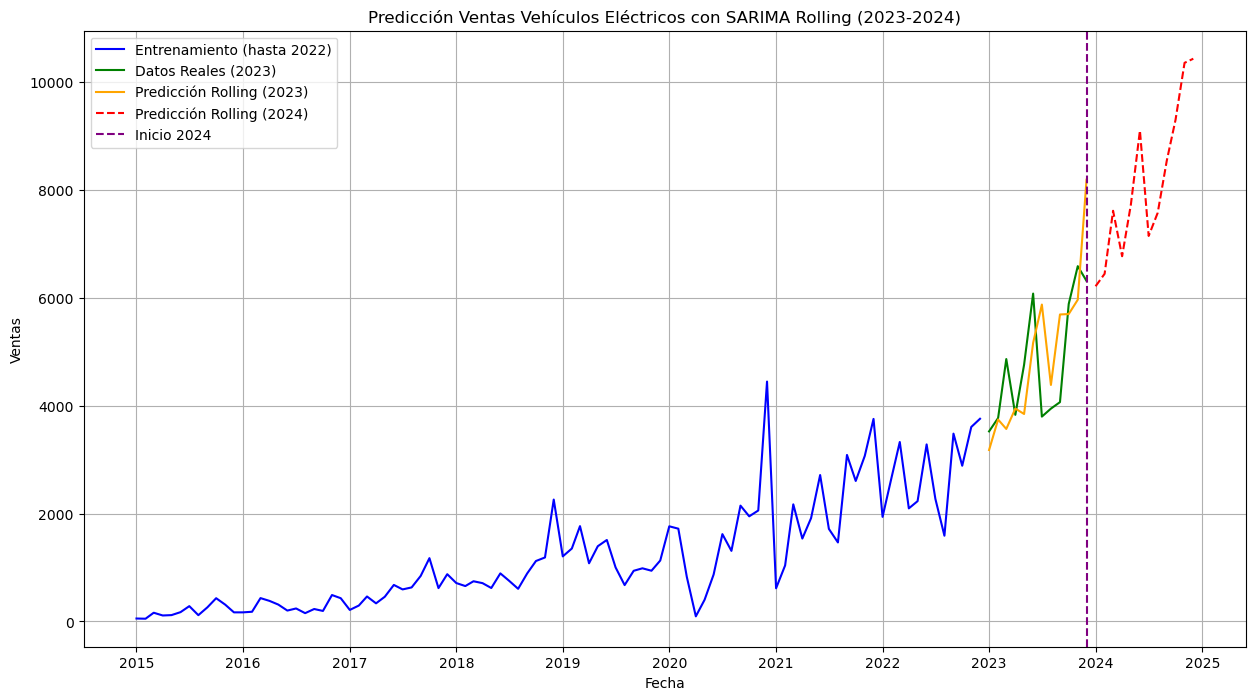

Predicciones Rolling para 2024:
2024-01: 6210 ventas
2024-02: 6440 ventas
2024-03: 7608 ventas
2024-04: 6766 ventas
2024-05: 7723 ventas
2024-06: 9094 ventas
2024-07: 7141 ventas
2024-08: 7571 ventas
2024-09: 8534 ventas
2024-10: 9291 ventas
2024-11: 10349 ventas
2024-12: 10425 ventas


In [1]:
# Importaciones
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Cargar datos
data = pd.read_excel('exports/ts_final.xlsx')
data['fecha'] = pd.to_datetime(data['ANO'].astype(str) + '-' + data['MES'].astype(str) + '-01')
data.set_index('fecha', inplace=True)
ts = data['ventas_electrico']

# Dividir en entrenamiento (hasta 2022) y prueba (2023)
train = ts[:'2022-12-01']
test = ts['2023-01-01':]

# Mejores parámetros encontrados previamente
best_order = (1, 2, 3)
best_seasonal_order = (2, 1, 0, 12)

# Función rolling forecast
def rolling_forecast(train_data, test_data, order, seasonal_order, window_size=None):
    if window_size is None:
        window_size = len(train_data)
    
    predictions = []
    for i in range(len(test_data)):
        train_window = train_data[-window_size:]
        model = SARIMAX(train_window, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        pred = model_fit.forecast(steps=1)
        predictions.append(pred.iloc[0])
        train_data = pd.concat([train_data, test_data.iloc[i:i+1]])
    return pd.Series(predictions, index=test_data.index)

# Predicciones rolling para 2023
rolling_pred = rolling_forecast(train, test, best_order, best_seasonal_order, window_size=36)

# Métricas de evaluación
rmse_rolling = np.sqrt(mean_squared_error(test, rolling_pred))
mape_rolling = mean_absolute_percentage_error(test, rolling_pred)

print(f"RMSE (Rolling): {rmse_rolling:.2f}")
print(f"MAPE (Rolling): {mape_rolling:.4f} ({mape_rolling*100:.2f}%)")

# Ahora predecimos 2024 usando rolling forecast:
future_steps = 12
future_dates = pd.date_range(start='2024-01-01', periods=future_steps, freq='MS')

# Usamos los datos reales hasta diciembre de 2023 como base
train_full = ts
predictions_2024 = []

for i in range(future_steps):
    train_window = train_full[-36:]
    model = SARIMAX(train_window, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=False)
    pred = model_fit.forecast(steps=1)
    predictions_2024.append(pred.iloc[0])
    train_full = pd.concat([train_full, pd.Series(pred.iloc[0], index=[future_dates[i]])])

predictions_2024_series = pd.Series(predictions_2024, index=future_dates)

# Visualización de resultados
plt.figure(figsize=(15, 8))
plt.plot(train, label='Entrenamiento (hasta 2022)', color='blue')
plt.plot(test, label='Datos Reales (2023)', color='green')
plt.plot(rolling_pred, label='Predicción Rolling (2023)', color='orange')
plt.plot(predictions_2024_series, label='Predicción Rolling (2024)', color='red', linestyle='--')
plt.axvline(x=test.index[-1], color='purple', linestyle='--', label='Inicio 2024')

plt.title('Predicción Ventas Vehículos Eléctricos con SARIMA Rolling (2023-2024)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True)
plt.show()

# Mostrar predicciones 2024
print("Predicciones Rolling para 2024:")
for i, pred in enumerate(predictions_2024):
    month = i + 1
    print(f"2024-{month:02d}: {pred:.0f} ventas")
